In [1]:
# simple generative adversarial network
# this version uses simple images, the MNIST dataset

In [2]:
# conventional PyTorch imports
import torch
import torch.nn as nn
#import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
import random
import pandas

In [4]:
import numpy
import matplotlib.pyplot as plt

In [5]:
# function to generate uniform random data
# size parameter is length of tensor

def generate_random(size):
    #return torch.rand(size)
    return torch.randn(size)

generate_random(5)

tensor([-1.1572,  0.8475, -1.2456, -0.4900, -0.1101])

In [6]:
# dataset class

class MnistDataset(torch.utils.data.Dataset):
    
    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass
    
    def __len__(self):
        return len(self.data_df)
    
    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        image_target = torch.zeros((10))
        image_target[label] = 1.0
        
        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0
        
        # return label, image data tensor and target tensor
        return label, image_values, image_target
    
    def plot_image(self, index):
        arr = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(arr, interpolation='none', cmap='Blues')
        pass
    
    pass


In [7]:
# subclass PyTorch dataset class, loads actual data, parses it into targets and pizel data

mnist_dataset = MnistDataset('mnist_data/mnist_test.csv')

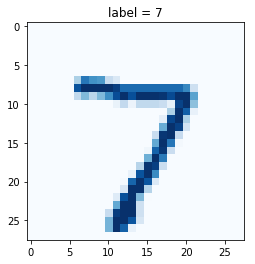

In [8]:
mnist_dataset.plot_image(0)

In [9]:
# from https://github.com/pytorch/vision/issues/720

class View(nn.Module):
    def __init__(self, shape):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        return x.view(*self.shape)

In [10]:
# discriminator class

class Discriminator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View((1, 784)),
            nn.Linear(784, 200),
            nn.Sigmoid(),
            nn.Linear(200, 1),
            nn.Sigmoid()
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, inputs, targets):
        # calculate the output of the network
        outputs = self.forward(inputs)
        
        # calculate error
        loss = self.error_function(outputs, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 1.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

In [11]:
# create Discriminator and test it

D = Discriminator()

# train Discriminator

epochs = 1

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    
    for label, image_data_tensor, target_tensor in mnist_dataset:
        
        # train discriminator on real data
        D.train(image_data_tensor.view(1, 1, 28, 28), torch.FloatTensor([1.0]).view(1,1))
        
        # train discriminator on false (random) data
        D.train(generate_random(784).view(1, 1, 28, 28), torch.FloatTensor([0.0]).view(1,1))
    
        pass
    
    pass


training epoch 1 of 1


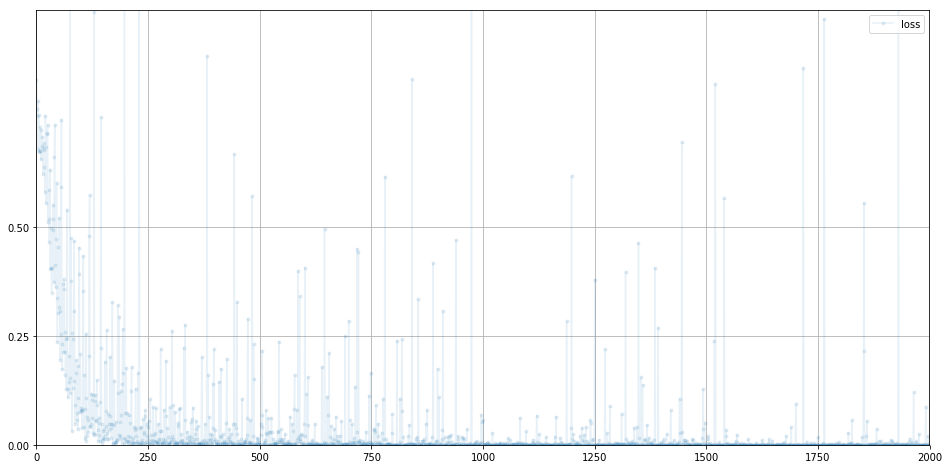

In [12]:
# plot discriminator error

D.plot_progress()

In [13]:
# manually check D can indeed discriminate between real and fake data

print(D.forward(generate_random(784).view(1, 1, 28, 28)).item())
print(D.forward(generate_random(784).view(1, 1, 28, 28)).item())
print(D.forward(generate_random(784).view(1, 1, 28, 28)).item())
print(D.forward(generate_random(784).view(1, 1, 28, 28)).item())

print(D.forward(mnist_dataset[random.randint(0,10000)][1].view(1, 1, 28, 28)).item())
print(D.forward(mnist_dataset[random.randint(0,10000)][1].view(1, 1, 28, 28)).item())
print(D.forward(mnist_dataset[random.randint(0,10000)][1].view(1, 1, 28, 28)).item())
print(D.forward(mnist_dataset[random.randint(0,10000)][1].view(1, 1, 28, 28)).item())


1.7451091480324976e-05
7.993968029040843e-05
0.010333934798836708
0.07996287941932678
0.9998621940612793
0.999036431312561
0.471552312374115
0.9985116124153137


In [14]:
# generator class

class Generator(nn.Module):
    
    def __init__(self):
        # initialise parent pytorch class
        super().__init__()
        
        # define neural network layers
        self.model = nn.Sequential(
            View((1,100)),
            
            nn.Linear(100, 500),
            nn.Sigmoid(),
            
            nn.Linear(500, 784),
            nn.Sigmoid(),
            
            View((1,1,28,28))
        )
        
        # create error function
        self.error_function = torch.nn.BCELoss()

        # create optimiser, using simple stochastic gradient descent
        self.optimiser = torch.optim.SGD(self.parameters(), lr=0.01)
        
        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []
        pass
    
    
    def forward(self, inputs):
        # simply run model
        return self.model(inputs)
    
    
    def train(self, D, inputs, targets):
        # calculate the output of the network
        g_output = self.forward(inputs)
        
        # pass onto Discriminator
        d_output = D.forward(g_output)
        
        # calculate error
        loss = D.error_function(d_output, targets)
        
        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 1000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, and update the weights.
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()
        pass
    
    
    def save(self, path):
        torch.save(self.state_dict(), path)
        pass
    
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        #self.eval()
        pass
    
    
    def plot_images(self):
        # plot a 3 column, 2 row array of sample images
        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random(100).view(1,1,10,10)).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass
    
    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0, 2.0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5))
        pass
    
    pass

torch.Size([1, 1, 28, 28])


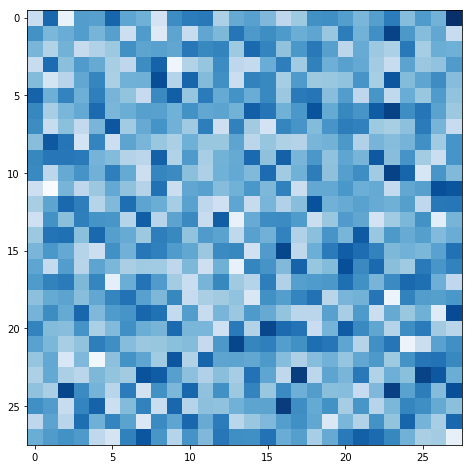

In [15]:
# scratch

G = Generator()

print(G(generate_random(100).view(1, 1, 10, 10)).shape)

plt.figure(figsize = (16,8))
plt.imshow(G.forward(generate_random(100).view(1,1,10,10)).view(28,28).detach().cpu().numpy(), 
           interpolation='none',
           cmap='Blues')

In [16]:
# create Discriminator and Generator

D = Discriminator()
G = Generator()

In [17]:
# train Discriminator and Generator

epochs = 1

for i in range(epochs):
    print('training epoch', i+1, "of", epochs)
    
    for label, image_data_tensor, target_tensor in mnist_dataset:
      
        # train discriminator on real data
        D.train(image_data_tensor.view(1, 1, 28, 28), torch.FloatTensor([1.0]).view(1,1))

        # train discriminator on false
        # use detach() so only D is updated, not G
        D.train(G.forward(generate_random(100).view(1, 1, 10, 10)).detach(), torch.FloatTensor([0.0]).view(1,1))
        
        # train generator
        G.train(D, generate_random(100).view(1, 1, 10, 10), torch.FloatTensor([1.0]).view(1,1))
        
        pass
    
    pass


training epoch 1 of 1
counter =  1000
counter =  2000
counter =  3000
counter =  4000
counter =  5000
counter =  6000
counter =  7000
counter =  8000
counter =  9000
counter =  10000


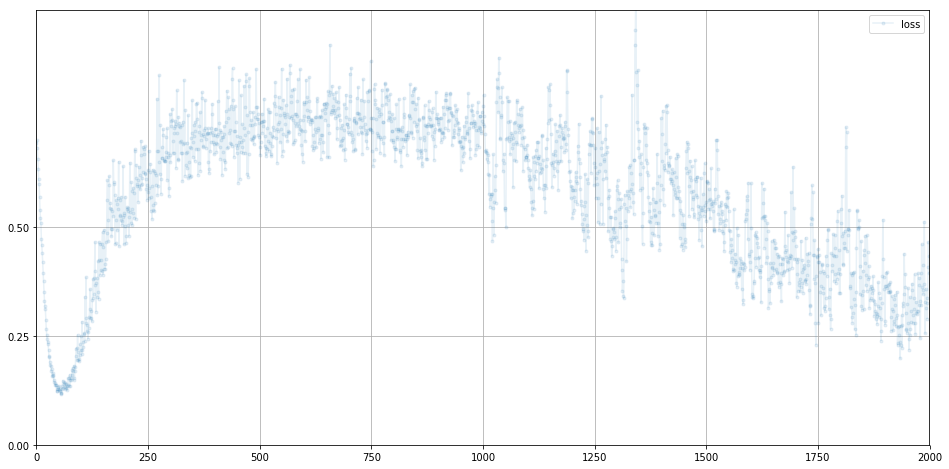

In [18]:
# plot discriminator error

D.plot_progress()

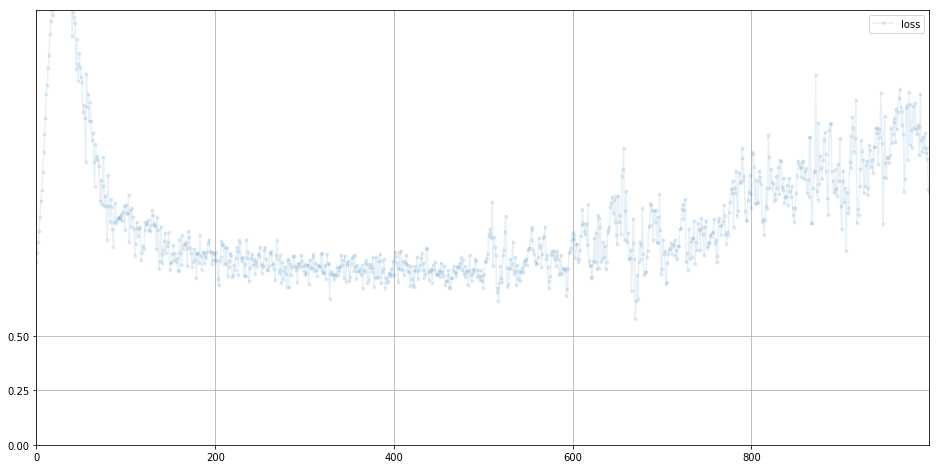

In [19]:
# plot generator error

G.plot_progress()

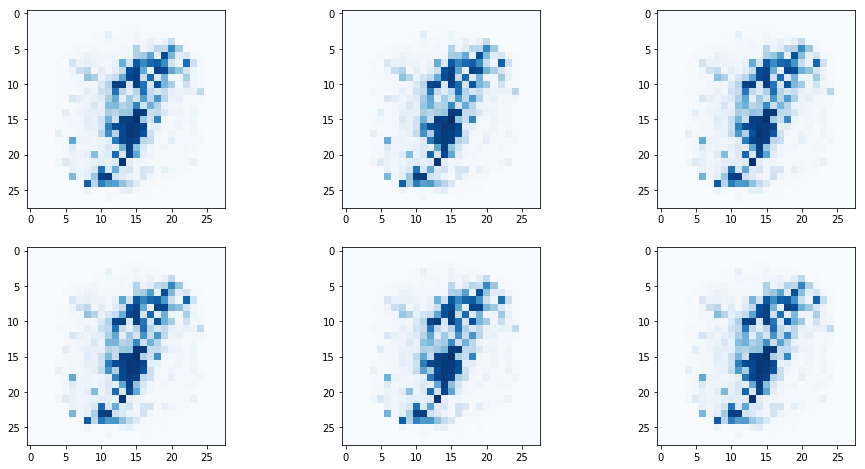

In [20]:
# show generator output

G.plot_images()

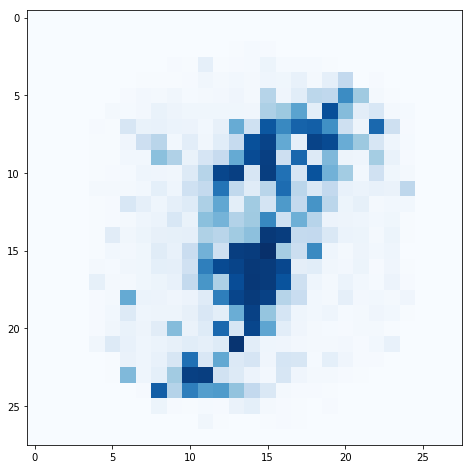

In [21]:
## expts

seed = torch.zeros(100)
seed[random.randint(0,99)] = 1

plt.figure(figsize = (16,8))
plt.imshow(G.forward(seed.view(1,1,10,10)).view(28,28).detach().cpu().numpy(), 
           interpolation='none',
           cmap='Blues')